In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/chest xray batch.zip"

Archive:  /content/drive/MyDrive/chest xray batch.zip
   creating: chest xray batch/batch 1/
   creating: chest xray batch/batch 1/train/
   creating: chest xray batch/batch 1/train/Images/
  inflating: chest xray batch/batch 1/train/Images/cxrimage_0.png  
  inflating: chest xray batch/batch 1/train/Images/cxrimage_1.png  
  inflating: chest xray batch/batch 1/train/Images/cxrimage_10.png  
  inflating: chest xray batch/batch 1/train/Images/cxrimage_100.png  
  inflating: chest xray batch/batch 1/train/Images/cxrimage_101.png  
  inflating: chest xray batch/batch 1/train/Images/cxrimage_102.png  
  inflating: chest xray batch/batch 1/train/Images/cxrimage_103.png  
  inflating: chest xray batch/batch 1/train/Images/cxrimage_104.png  
  inflating: chest xray batch/batch 1/train/Images/cxrimage_105.png  
  inflating: chest xray batch/batch 1/train/Images/cxrimage_106.png  
  inflating: chest xray batch/batch 1/train/Images/cxrimage_107.png  
  inflating: chest xray batch/batch 1/train/I

In [ ]:
from keras.layers import Conv2D,Conv2DTranspose,MaxPooling2D,Dropout,Concatenate,Input
from keras import Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [ ]:
def double_conv_block(prev_layer, filter_count):
   new_layer = Conv2D(filter_count, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(prev_layer)
   new_layer = Conv2D(filter_count, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(new_layer)
   return new_layer

In [ ]:
def downsample_block(prev_layer, filter_count):
   skip_features = double_conv_block(prev_layer, filter_count)
   down_sampled = MaxPooling2D(2)(skip_features)
   down_sampled = Dropout(0.3)(down_sampled)
   return skip_features, down_sampled

In [ ]:
def upsample_block(prev_layer, skipped_features, n_filters):
   upsampled = Conv2DTranspose(n_filters, 3, 2, padding="same")(prev_layer)
   upsampled = Concatenate()([upsampled, skipped_features])
   upsampled = Dropout(0.3)(upsampled)
   upsampled = double_conv_block(upsampled, n_filters)
   return upsampled

In [ ]:
def make_unet():
   inputs = Input(shape=(128,128,1))


   skipped_fmaps_1, downsample_1 = downsample_block(inputs, 64)
   skipped_fmaps_2, downsample_2 = downsample_block(downsample_1, 128)
   skipped_fmaps_3, downsample_3 = downsample_block(downsample_2, 256)
   skipped_fmaps_4, downsample_4 = downsample_block(downsample_3, 512)

   bottleneck = double_conv_block(downsample_4, 1024)

   upsample_1 = upsample_block(bottleneck, skipped_fmaps_4, 512)
   upsample_2 = upsample_block(upsample_1, skipped_fmaps_3, 256)
   upsample_3 = upsample_block(upsample_2, skipped_fmaps_2, 128)
   upsample_4 = upsample_block(upsample_3, skipped_fmaps_1, 64)


   outputs = Conv2D(1, 1, padding="same", activation = "sigmoid")(upsample_4)

   unet_model = Model(inputs, outputs, name="U-Net")

   return unet_model

In [ ]:
from tensorflow.keras.utils import plot_model
from matplotlib.pyplot import figure

def model_plotter(model):
  plot_model(
      model,
      to_file="model.png",
      show_shapes=True,
      show_dtype=True,
      show_layer_names=True,
      rankdir="TB",
      expand_nested=True,
      dpi=96,
      layer_range=None,  )
  figure(figsize=(100,100))
  plt.imshow(np.asarray(Image.open("model.png")))
  plt.axis("off")
  plt.show()

In [ ]:
u_net = make_unet()

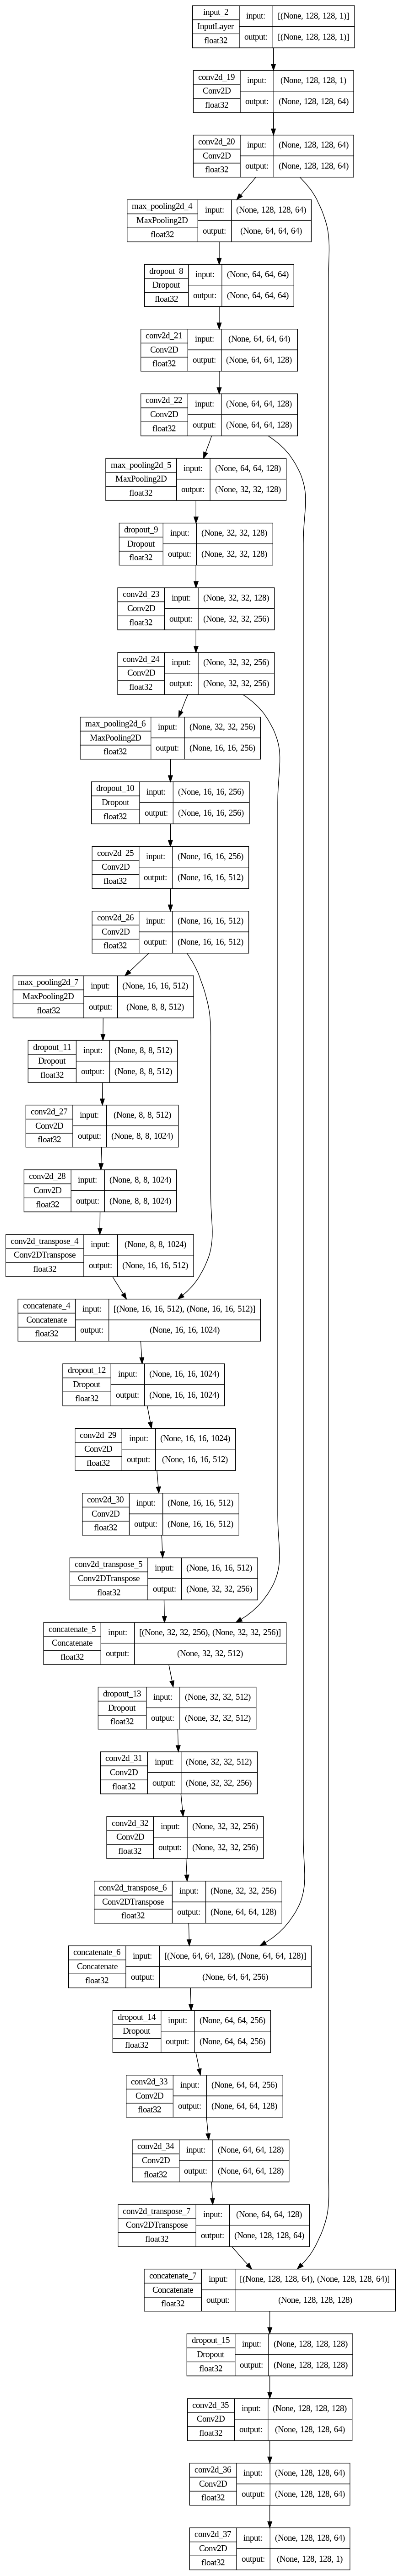

In [ ]:
model_plotter(u_net)

In [ ]:
images = os.listdir("/content/chest xray batch/batch 1/train/Images")
masks = os.listdir("/content/chest xray batch/batch 1/train/Mask")

In [ ]:
v_images = os.listdir("/content/chest xray batch/batch 1/Val/images")
v_masks = os.listdir("/content/chest xray batch/batch 1/Val/mask")

In [ ]:
print(len(images)==len(masks))
print(len(v_images)==len(v_masks))

True
True


In [ ]:
masks[:10]

['cxrmask_403.jpeg',
 'cxrmask_132.jpeg',
 'cxrmask_426.jpeg',
 'cxrmask_430.jpeg',
 'cxrmask_111.jpeg',
 'cxrmask_248.jpeg',
 'cxrmask_78.jpeg',
 'cxrmask_26.jpeg',
 'cxrmask_50.jpeg',
 'cxrmask_466.jpeg']

In [ ]:
images[:10]

['cxrimage_72.png',
 'cxrimage_404.png',
 'cxrimage_391.png',
 'cxrimage_476.png',
 'cxrimage_408.png',
 'cxrimage_109.png',
 'cxrimage_16.png',
 'cxrimage_147.png',
 'cxrimage_120.png',
 'cxrimage_13.png']

In [ ]:
masks.sort()
images.sort()
v_masks.sort()
v_images.sort()

In [ ]:
temp = 0
while temp<20:
  print(images[temp].split("_")[1].split(".")[0] == masks[temp].split("_")[1].split(".")[0])
  temp+=1

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
import random

i = random.randint(0,len(images)-1)
img = np.asarray(Image.open(os.path.join("/content/chest xray batch/batch 1/train/Images",images[i])))
mask = np.asarray(Image.open(os.path.join("/content/chest xray batch/batch 1/train/Mask",masks[i])))
print(img.shape,mask.shape)

(512, 512, 4) (512, 512, 3)


In [ ]:
len(images)

500

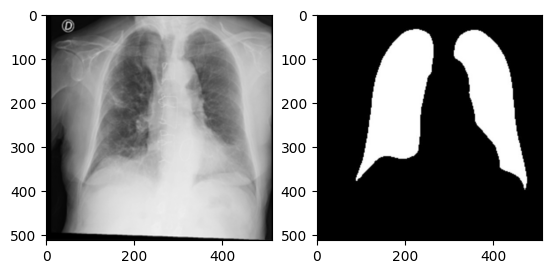

In [ ]:
plt.subplot(1,2,1)
plt.imshow(img[:,:,:3]) #rgba to rgb

plt.subplot(1,2,2)
plt.imshow(mask)

plt.show()

In [ ]:

def make_dataset(validation=False):
  x = []
  y = []
  if(validation):
    for i,(image,mask) in enumerate(zip(v_images[:1500],v_masks[:1500])):
      print("\r"+str(i+1)+"/"+str(len(v_images)),end="")

      image = Image.open(os.path.join("/content/chest xray batch/batch 1/Val/images",image)).convert('L')
      mask = Image.open(os.path.join("/content/chest xray batch/batch 1/Val/mask",mask)).convert('L')

      image = np.asarray(image.resize((128,128)))/255.
      mask = np.asarray(mask.resize((128,128)))/255.

      x.append(image)
      y.append(mask)
  else:
    for i,(image,mask) in enumerate(zip(images[:3500],masks[:3500])):
      print("\r"+str(i+1)+"/"+str(len(images)),end="")

      image = Image.open(os.path.join("/content/chest xray batch/batch 1/train/Images",image)).convert('L')
      mask = Image.open(os.path.join("/content/chest xray batch/batch 1/train/Mask",mask)).convert('L')

      image = np.asarray(image.resize((128,128)))/255.
      mask = np.asarray(mask.resize((128,128)))/255.

      x.append(image)
      y.append(mask)

  return np.array(x),np.array(y)

In [ ]:
x,y = make_dataset()

500/500

In [ ]:
v_x,v_y = make_dataset(True)

500/500

In [ ]:
x,y = np.expand_dims(x,axis=-1),np.expand_dims(y,axis=-1)
v_x,v_y = np.expand_dims(v_x,axis=-1),np.expand_dims(v_y,axis=-1)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1

image_generator = image_datagen.flow(
    x,
    batch_size=16,
    seed=seed)

mask_generator = mask_datagen.flow(
    y,
    batch_size=16,
    seed=seed)

train_generator = zip(image_generator, mask_generator)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_test_datagen = ImageDataGenerator()
mask_test_datagen = ImageDataGenerator()

seed = 1

image_test_generator = image_test_datagen.flow(
    v_x,
    batch_size=16,
    seed=seed)

mask_test_generator = mask_test_datagen.flow(
    v_y,
    batch_size=16,
    seed=seed)

valid_generator = zip(image_test_generator, mask_test_generator)

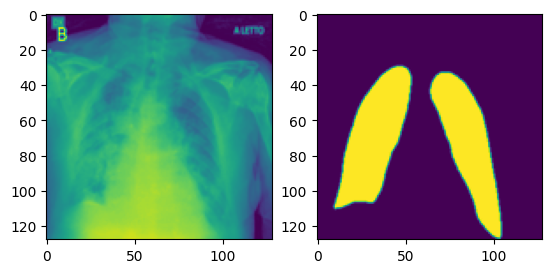

In [ ]:
i = random.randint(0,len(x))

img = x[i]
mask = y[i]

plt.subplot(1,2,1)
plt.imshow(np.squeeze(img))

plt.subplot(1,2,2)
plt.imshow(np.squeeze(mask))

plt.show()

In [ ]:
u_net.compile(optimizer="adam",loss="binary_crossentropy",metrics="accuracy")

In [ ]:
model_history = u_net.fit(train_generator,epochs=20,validation_data=valid_generator,steps_per_epoch = int(x.shape[0] / 8),validation_steps = int(v_x.shape[0] / 8))

Epoch 1/20
62/62 [==============================] - 58s 476ms/step - loss: 1.3724 - accuracy: 0.7176 - val_loss: 0.4620 - val_accuracy: 0.7228
Epoch 2/20
62/62 [==============================] - 20s 322ms/step - loss: 0.4533 - accuracy: 0.7214 - val_loss: 0.3779 - val_accuracy: 0.7548
Epoch 3/20
62/62 [==============================] - 20s 325ms/step - loss: 0.3971 - accuracy: 0.7669 - val_loss: 0.3170 - val_accuracy: 0.8604
Epoch 4/20
62/62 [==============================] - 20s 328ms/step - loss: 0.3555 - accuracy: 0.8023 - val_loss: 0.2817 - val_accuracy: 0.8620
Epoch 5/20
62/62 [==============================] - 21s 343ms/step - loss: 0.3012 - accuracy: 0.8291 - val_loss: 0.2027 - val_accuracy: 0.8914
Epoch 6/20
62/62 [==============================] - 22s 350ms/step - loss: 0.2354 - accuracy: 0.8567 - val_loss: 0.1614 - val_accuracy: 0.9088
Epoch 7/20
62/62 [==============================] - 22s 354ms/step - loss: 0.1989 - accuracy: 0.8691 - val_loss: 0.1186 - val_accuracy: 0.9229

In [ ]:
u_net.save("u_net.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


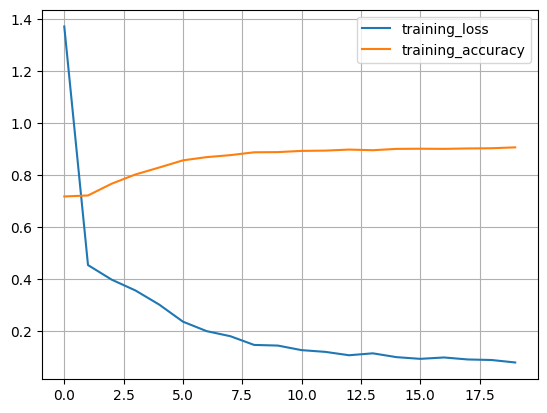

In [ ]:
plt.plot(model_history.history['loss'], label = 'training_loss')
plt.plot(model_history.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

1/1 [==============================] - 2s 2s/step


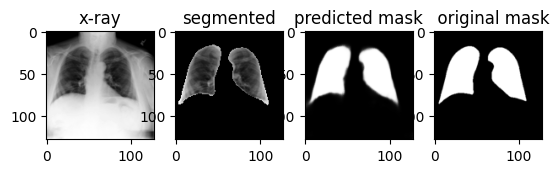

In [ ]:
i = random.randint(0,len(v_x)-1)

original = v_x[i].copy()
original_mask = v_y[i].copy()

mask = u_net.predict(np.expand_dims(original,axis=0))


segmented = np.squeeze(original).copy()
segmented[np.squeeze(mask)<0.2] = 0

plt.subplot(1,4,1)
plt.imshow(np.squeeze(original),cmap="gray")
plt.title("x-ray")


plt.subplot(1,4,2)
plt.imshow(segmented,cmap="gray")
plt.title("segmented")


plt.subplot(1,4,3)
plt.imshow(np.squeeze(mask[0]),cmap="gray")
plt.title("predicted mask")

plt.subplot(1,4,4)
plt.imshow(np.squeeze(original_mask),cmap="gray")
plt.title("  original mask")


plt.show()